<a href="https://colab.research.google.com/github/MarkzDG/Codigos_oceano/blob/main/Estadistica_olas/Tratamiento_Estad%C3%ADstico_en_Registros_de_Olas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se tiene un registro del nivel del mar y mediante este se quiere conocer características estadísticas del oleaje.

Notación: H → Altura de la ola, T → Período entre olas

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Tratamiento Estadístico

In [4]:
!gdown 1kH-B8fQSYCGOffsMpwjVHCJ5npSQAwuN -O datos.TXT

Downloading...
From: https://drive.google.com/uc?id=1kH-B8fQSYCGOffsMpwjVHCJ5npSQAwuN
To: /content/datos.TXT
100% 14.9k/14.9k [00:00<00:00, 43.2MB/s]


In [5]:
#Se cargan los datos y se acomodan en una única columna
crudos=np.loadtxt('datos.TXT',skiprows=1)
datos=pd.DataFrame(np.squeeze(crudos.reshape((2400,1))),columns=['registro'])
#Se lee el encabezado del archivo para obtener información de la fecha/hora
from pathlib import Path
txt = Path('datos.TXT').read_text()
txt[0:45]

'COPUAP * 02/05/81 0400 * 20 MIN. * DT:0.5 SEG'

In [6]:
#Se agrega la información temporal de la medición
tiempo=pd.date_range('1981-07-02 16:00:00',periods=len(datos),freq='0.5S')
datos.set_index(tiempo,inplace=True)

[Text(0, 0.5, 'Registro (m)'),
 Text(0.5, 1.0, 'COPUAP * 02/05/81 0400 * 20 MIN. * DT:0.5 SEG')]

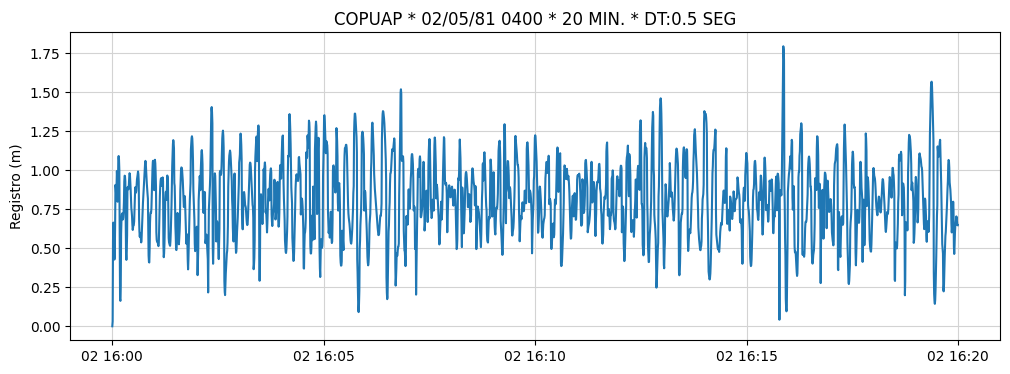

In [8]:
#@title Registro crudo en m
fig,axs=plt.subplots(1,1,figsize=(12,4))
axs.plot(datos/1000)
axs.grid(axis='both',color='lightgray')
axs.set(ylabel='Registro (m)',title=txt[0:45])

### Filtramos tendencia

In [9]:
## Filtramos la tendencia
from statsmodels.tsa.tsatools import detrend
datos['re_cero'] = detrend(datos, order=2)

[Text(0, 0.5, 'Registro (m)'),
 Text(0.5, 1.0, 'COPUAP * 02/05/81 0400 * 20 MIN. * DT:0.5 SEG')]

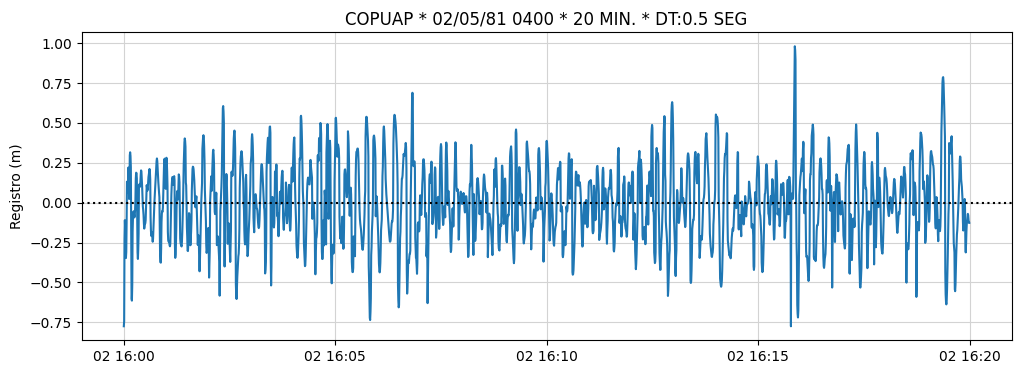

In [10]:
#@title Niveles instantáneos alrededor de la superficie libre
fig,axs=plt.subplots(1,1,figsize=(12,4))
axs.plot(datos['re_cero']/1000)
axs.axhline(0,ls=':',color='k')
axs.grid(axis='both',color='lightgray')
axs.set(ylabel='Registro (m)',title=txt[0:45])

[Text(0.5, 0, 'niveles (mm)'),
 Text(0, 0.5, 'casos'),
 Text(0.5, 1.0, 'COPUAP * 02/05/81 0400 * 20 MIN. * DT:0.5 SEG'),

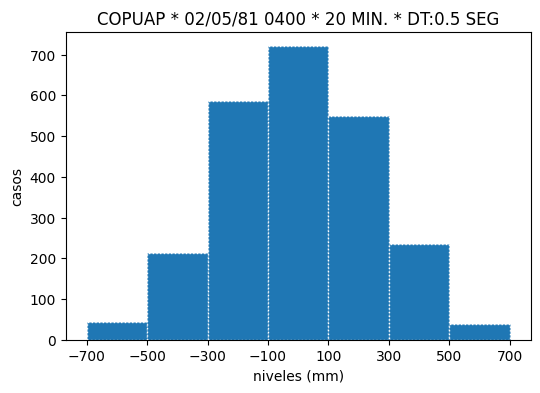

In [11]:
#@title Histograma de niveles instantáneos
ni=np.arange(-700,800,200)
fig,axs=plt.subplots(1,1,figsize=(6,4))
axs.hist(datos.re_cero,bins=ni,ls=':',edgecolor='white')
axs.set(xlabel='niveles (mm)',ylabel='casos',title=txt[0:45],xticks=ni)

In [12]:
cruces=datos['re_cero'].loc[(datos.re_cero.shift(1)<0)& (datos.re_cero>0)].to_frame() ##--> acá las cuento
cruces.insert(1,'ola',(np.arange(1,len(cruces)+1))) # acá le agrego una columna de números
print('Considerando el cruce "hacia arriba" este registro tiene %d olas'% (len(cruces)))

Considerando el cruce "hacia arriba" este registro tiene 154 olas


[Text(0, 0.5, 'Registro (mm)'),
 Text(0.5, 1.0, 'COPUAP * 02/05/81 0400 * 20 MIN. * DT:0.5 SEG')]

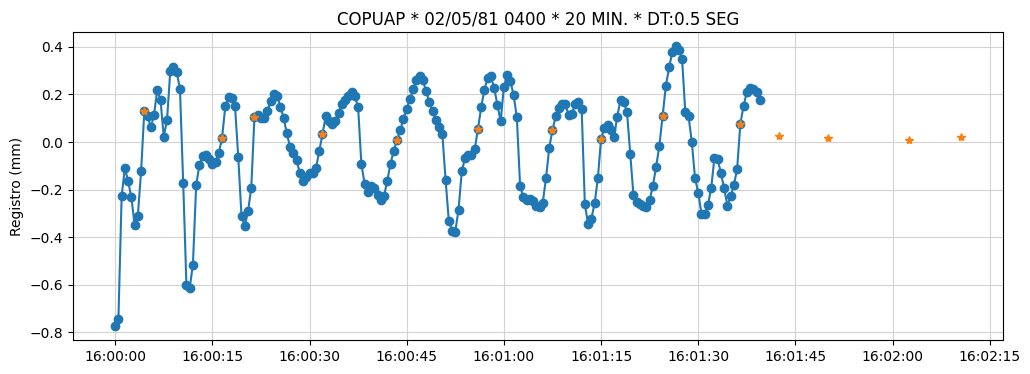

In [14]:
#@title Olas individuales
fig,axs=plt.subplots(1,1,figsize=(12,4))
axs.plot(datos.re_cero[0:200]/1000,'-o')
axs.plot(cruces.re_cero[0:14]/1000,'*')
axs.grid(axis='both',color='lightgray')
axs.set(ylabel='Registro (mm)',title=txt[0:45])

In [15]:
#Voy a juntar la información de los registros con los cruces que definen cada ola individual
datos=datos.join(cruces.ola)
datos.ola.fillna(method='ffill',inplace=True)

In [16]:
#@title [Hi,Ti] observados
cada_ola=pd.DataFrame(index=cruces.ola.values)
cada_ola['cresta']=datos.re_cero.groupby(datos.ola).max()
cada_ola['valle']=datos.re_cero.groupby(datos.ola).min()
cada_ola['H']=cada_ola['cresta']-cada_ola['valle']
cada_ola['puntos']=datos.re_cero.groupby(datos.ola).count()
cada_ola['T']=(cada_ola.puntos-1)/2
cada_ola.describe()

,cresta,valle,H,puntos,T
count,154.000000,154.000000,154.000000,154.000000,154.000000
mean,250.622229,-275.225061,525.847290,15.525974,7.262987
std,177.899384,177.638599,295.372585,7.008117,3.504058
min,0.647204,-774.548809,50.888339,4.000000,1.500000
25%,105.258511,-395.143231,325.694951,9.250000,4.125000
50%,224.597038,-256.353761,469.818229,15.000000,7.000000
75%,372.672380,-136.164948,691.365383,21.000000,10.000000
max,980.124648,-0.491062,1699.441098,32.000000,15.500000


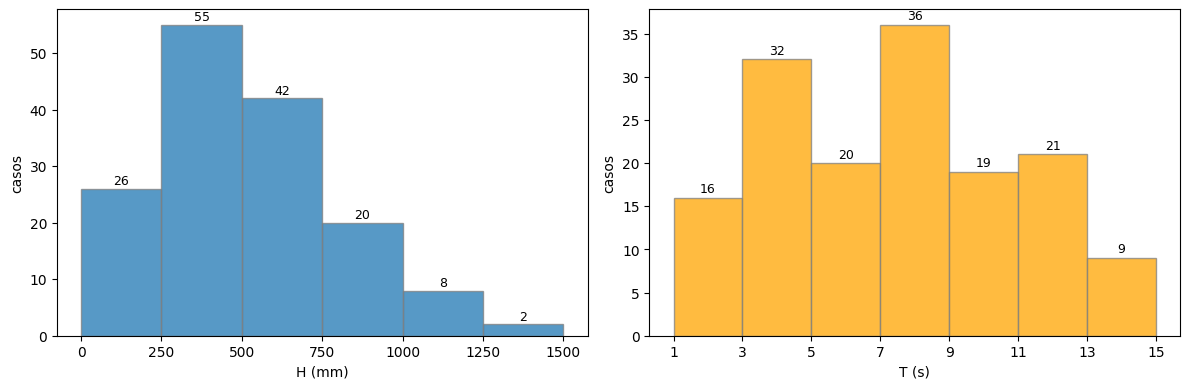

In [27]:
#@title Histogramas [Hi,Ti]
figs, axs = plt.subplots(1, 2, figsize=(12, 4))

# Histograma para la variable 'H'
bisH = np.arange(0, 1600, 250)
hist_H, edges_H, _ = axs[0].hist(cada_ola['H'], bins=bisH, edgecolor='gray', alpha=0.75)
axs[0].set(xticks=bisH, xlabel='H (mm)', ylabel='casos')

# Etiquetas de valores para el histograma de 'H'
rects_H = axs[0].patches
for rect, label in zip(rects_H, hist_H):
    height = rect.get_height()
    axs[0].text(rect.get_x() + rect.get_width() / 2, height + 0.25, int(label),
                ha='center', va='bottom', fontsize=9)

# Histograma para la variable 'T'
bisT = np.arange(1, 16, 2)
hist_T, edges_T, _ = axs[1].hist(cada_ola['T'], bins=bisT, edgecolor='gray', alpha=0.75, color='orange')
axs[1].set(xticks=bisT, xlabel='T (s)', ylabel='casos')

# Etiquetas de valores para el histograma de 'T'
rects_T = axs[1].patches
for rect, label in zip(rects_T, hist_T):
    height = rect.get_height()
    axs[1].text(rect.get_x() + rect.get_width() / 2, height + 0.25, int(label),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

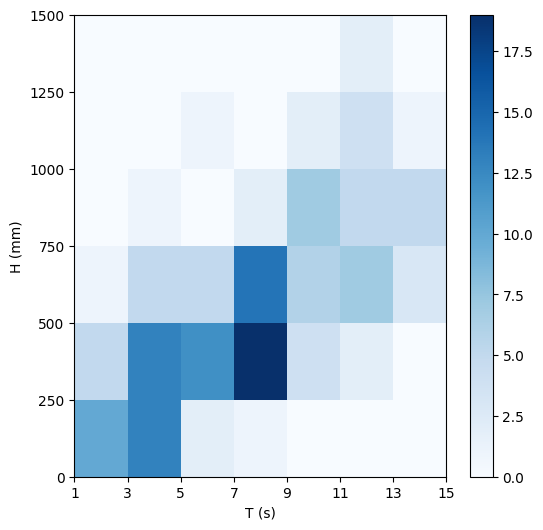

In [19]:
#@title Histograma bidimensional (heatmap) [Hi,Ti]
figs,axs=plt.subplots(1,1,figsize=(6,6))
hist,xed,yed,mesh=axs.hist2d(cada_ola['T'],cada_ola['H'],bins=[bisT,bisH],cmap='Blues')
axs.set(xticks=bisT,xlabel='T (s)',ylabel='H (mm)',yticks=bisH)
plt.colorbar(mesh)